<a href="https://colab.research.google.com/github/snikhil17/REGex_Internship/blob/main/Team%20Project%20-%203/1_Exploratory_Data_Analysis_(EDA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Problem**

- It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# **Given Data**
- The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# **Acknowledgements**

- The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

# **Importing Required Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings('ignore')

import pandas as pd


from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from imblearn.combine import SMOTETomek

## **Loading the Data**

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
df_train= pd.read_csv('/content/drive/MyDrive/New Folder/Copy of creditcard_stratified.csv')
df_test= pd.read_csv('/content/drive/MyDrive/New Folder/Copy of test.csv')
df_train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,kfold
0,0,171306.0,2.168118,-1.731966,-0.101423,-1.516228,-1.762327,0.107145,-1.803075,0.087421,-0.617820,1.430516,-1.132033,-0.548229,0.989762,-1.007329,0.142895,-0.110690,0.292566,0.222226,-0.358004,-0.298250,-0.126096,0.104613,0.337718,0.583060,-0.529252,-0.273834,0.060092,-0.017113,52.00,0,4.0
1,1,62395.0,-0.514037,0.953548,1.639592,-0.149570,0.061661,-0.210378,0.545380,0.203165,-0.678399,-0.191564,1.707444,0.803937,-0.082876,0.374202,0.381713,0.042487,-0.293247,-0.374638,-0.132844,0.076307,-0.133674,-0.327980,0.025932,0.205276,-0.322368,0.070640,0.277572,0.109626,5.85,0,4.0
2,2,43463.0,-0.671869,-0.399551,1.649636,-2.278123,-0.484760,-1.164731,0.155846,-0.030425,1.440249,-1.829221,-0.583126,0.890476,0.592870,-0.457628,0.409242,-0.194237,-0.481948,0.095075,-0.063800,0.116415,0.210261,0.594446,0.184314,0.430021,-0.644314,-0.342088,0.171030,0.207153,70.00,0,3.0
3,3,157918.0,2.084298,0.103235,-1.613616,0.485971,0.264824,-1.411857,0.598777,-0.504130,0.496313,-0.078829,-0.784751,0.783872,0.424063,0.359565,-0.384585,-0.843043,-0.117172,-0.719843,0.226709,-0.239673,0.002001,0.293965,0.029691,0.090537,0.383237,-0.224996,-0.031261,-0.065743,1.00,0,1.0
4,4,67461.0,1.286755,-1.194764,1.503195,-0.353358,-1.869471,0.605151,-1.749865,0.461911,0.668069,0.467496,0.024983,-0.197757,-1.296228,-0.960619,-1.907411,0.911665,0.595563,-0.603601,1.410409,-0.027345,0.155647,0.710105,-0.129878,0.051088,0.449721,-0.038945,0.073214,0.011353,5.80,0,1.0


# **EDA**
## **Missing Values**

In [64]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0


## **Duplicates**

In [65]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


## **Distribution of variables**

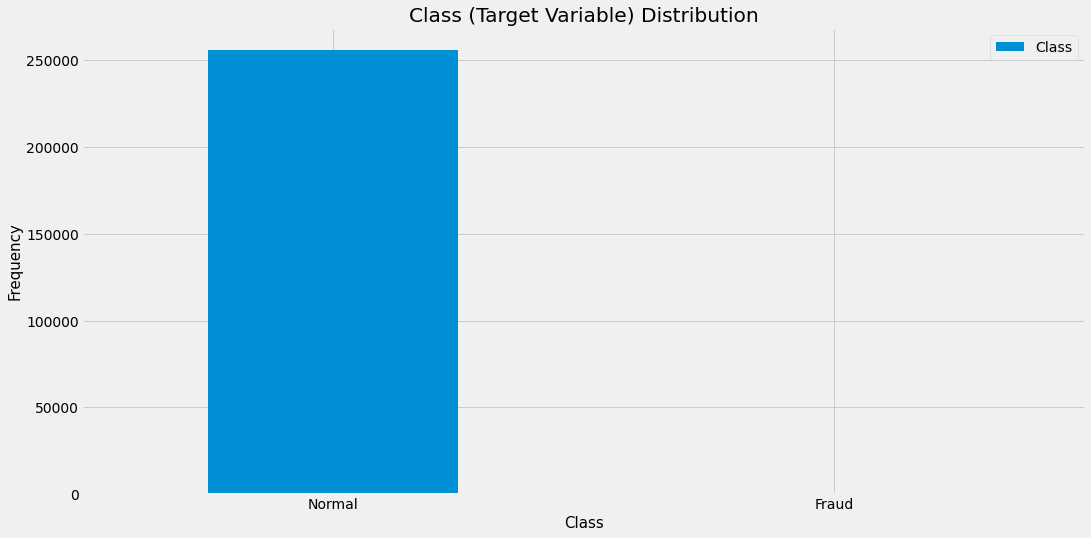

In [66]:
LABELS = ["Normal", "Fraud"]
count_classes = pd.value_counts(df_train['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Class (Target Variable) Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.legend()

### **Observation:**

---
- Above graph shows the data is imbalanced.
- We will not get good result if we do not take care of the imbalanced data.
- We will try to see the impact of imbalanced data in following steps too.


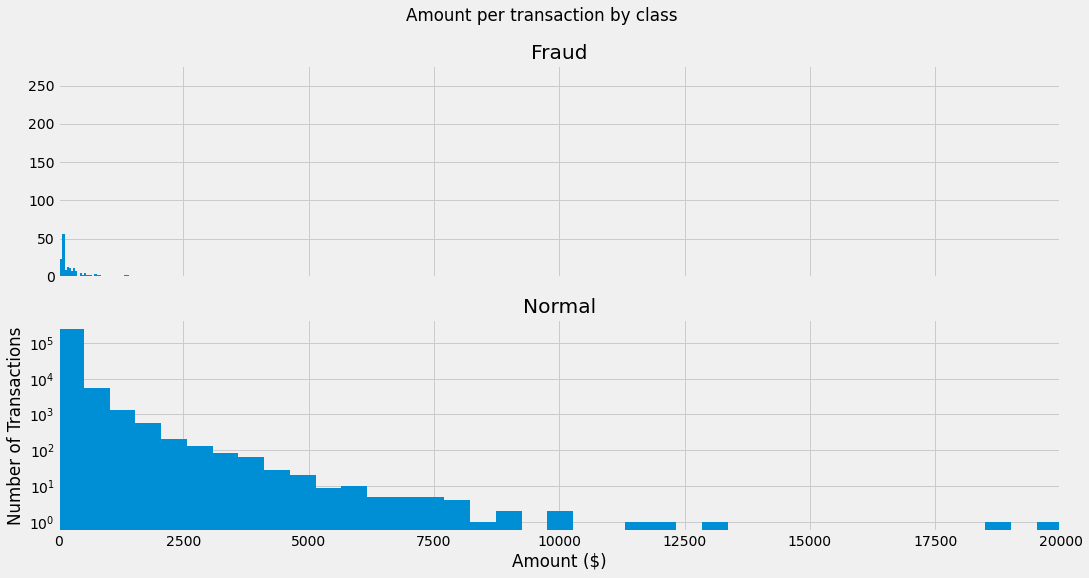

In [67]:
fraud = df_train[df_train['Class']==1]
normal = df_train[df_train['Class']==0]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

## **Observation:**

---
- We can clearly see that Fraud Transactions are of smaller amount and Normal transactions are small and huge.



# **Correlation:**

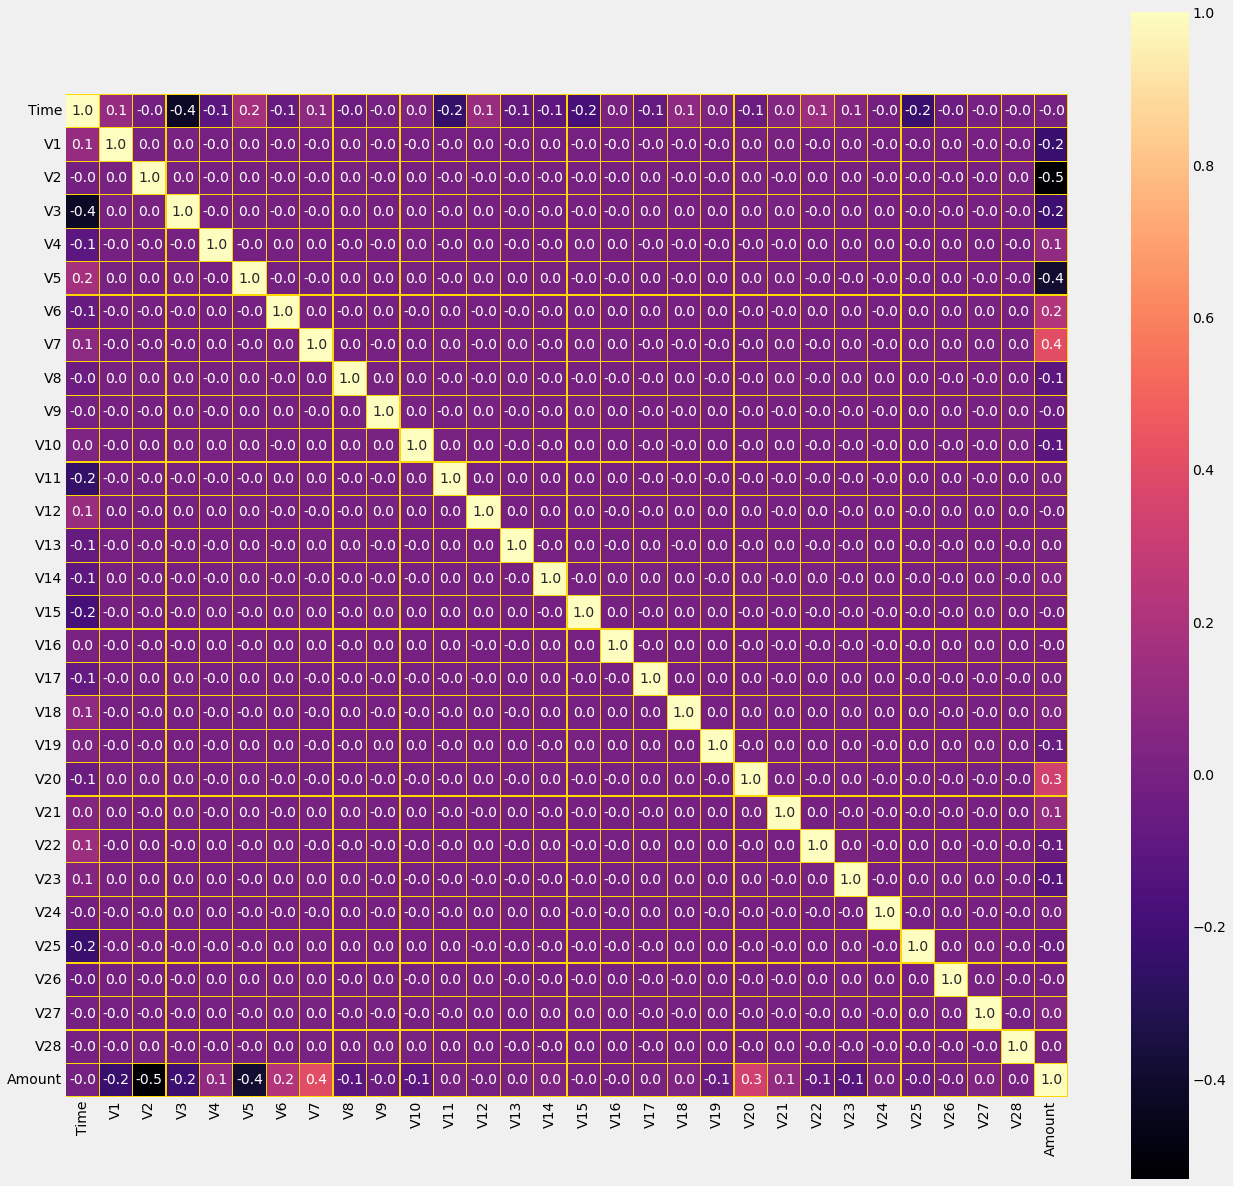

In [68]:
useful_features = [c for c in df_train.columns if c not in ("id","Class", "kfold")]
corrmat = df_train[useful_features].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_train[top_corr_features].corr(),annot=True,cmap="magma",fmt = '.1f', square = True, lw = 0.2, linecolor = 'gold')
plt.show()

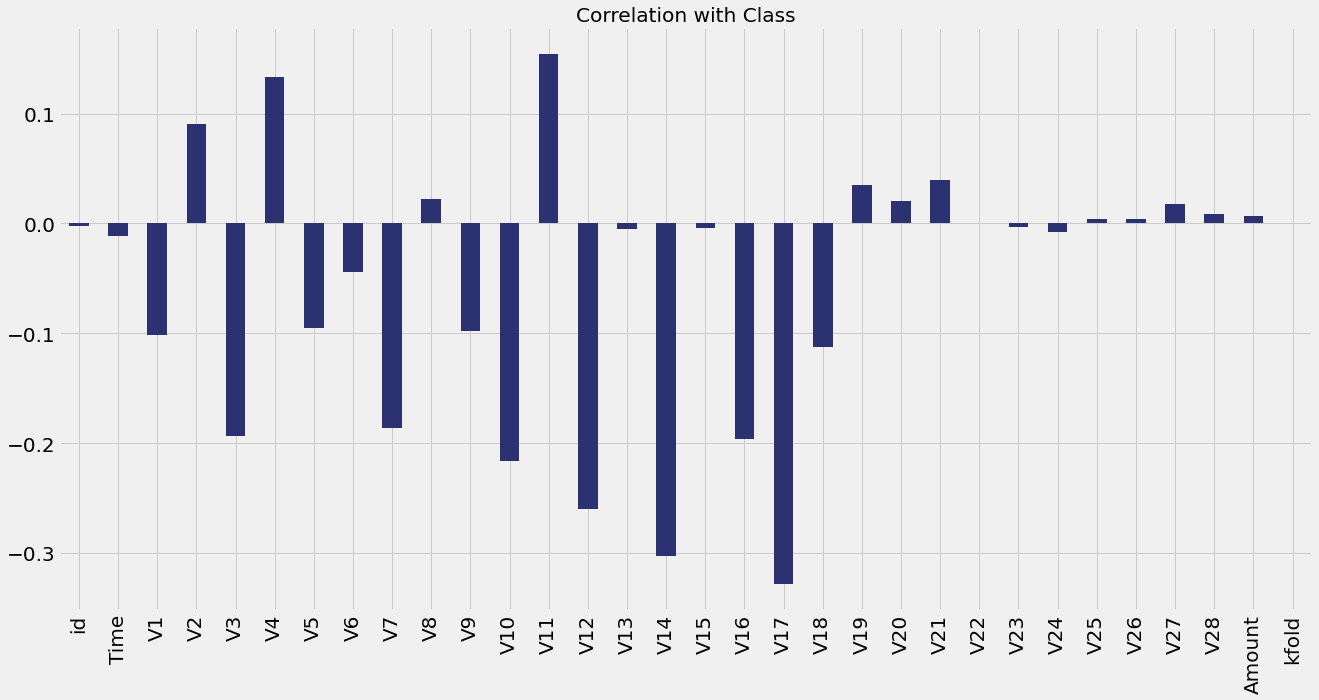

In [69]:
# Finding Correlation with target variable
(df_train.drop(['Class'], axis = 1)).corrwith(df_train.Class).plot.bar(cmap = 'crest_r',
        figsize = (20, 10), title = "Correlation with Class", fontsize = 20,
        rot = 90, grid = True)

# **Data Distribution and Outlier Detection**


## **Histogram**

- A histogram is a graphical representation of the distribution of data given by the user. Its appearance is similar to Bar-Graph except it is continuous. The towers or bars of a histogram are called bins. The height of each bin shows how many values from that data fall into that range.

## **Skewed**

- These distributions are sometimes called asymmetric or asymmetrical distributions as they don’t show any kind of symmetry.
- Symmetry means that one half of the distribution is a mirror image of the other half.
- For example, the normal distribution is a symmetric distribution with no skew. The tails are exactly the same.

## **Normal Distribution**

- A normal distribution, sometimes called the bell curve.
- The bell curve is symmetrical. Half of the data will fall to the left of the mean; half will fall to the right.
- The mean, mode and median are all equal.
- The curve is symmetric at the center (i.e. around the mean, μ).
- Exactly half of the values are to the left of center and exactly half the values are to the right.
- The total area under the curve is 1.
- The Standard Normal Model
- A standard normal model is a normal distribution with a mean of 0 and a standard deviation of 1.

## **Left side skewed**
- A left-skewed distribution has a long left tail.
- Left-skewed distributions are also called negatively-skewed distributions.
- That’s because there is a long tail in the negative direction on the number line.
- The mean is also to the left of the peak.

## **Right side skewed**
- A right-skewed distribution has a long right tail.
- Right-skewed distributions are also called positive-skew distributions.
- That’s because there is a long tail in the positive direction on the number line.



In [70]:

# creating index in a list
lst=['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class']

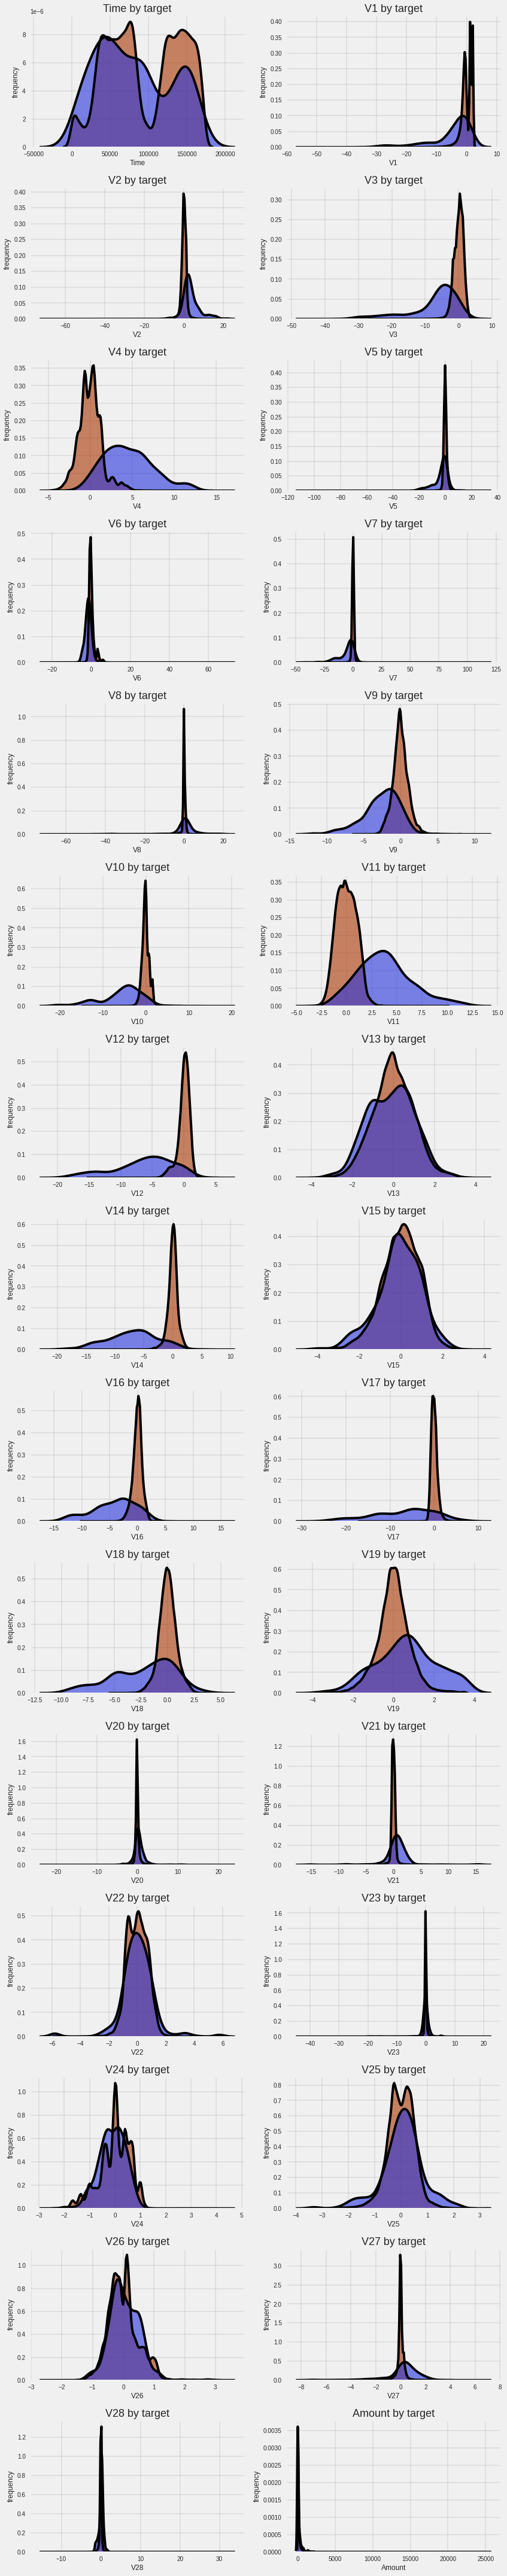

CPU times: user 58.4 s, sys: 4.79 s, total: 1min 3s
Wall time: 59.1 s


In [33]:
%%time



f,ax=plt.subplots(15,2,figsize=(12,60))
#f.delaxes(ax)
col = list(df_train.drop(['id','kfold'], axis = 1))
col = [e for e in col if e not in ('Class')]

for i,feature in enumerate(col):
    sns.distplot(df_train.drop(['id','kfold'], axis = 1)[df_train.drop(['id','kfold'], axis = 1)['Class']==1].dropna()[(feature)], ax=ax[i//2,i%2], kde_kws={"color":"black"}, hist=False )
    sns.distplot(df_train.drop(['id','kfold'], axis = 1)[df_train.drop(['id','kfold'], axis = 1)['Class']==0].dropna()[(feature)], ax=ax[i//2,i%2], kde_kws={"color":"black"}, hist=False )

    # Get the two lines from the ax[i//2,i%2]es to generate shading
    l1 = ax[i//2,i%2].lines[0]
    l2 = ax[i//2,i%2].lines[1]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    x2 = l2.get_xydata()[:,0]
    y2 = l2.get_xydata()[:,1]
    ax[i//2,i%2].fill_between(x2,y2, color="#A73602", alpha=0.6)
    ax[i//2,i%2].fill_between(x1,y1, color="#2734DE", alpha=0.6)

    #grid
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.3)
    
    ax[i//2,i%2].set_title('{} by target'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('Modality', fontsize=12)

    #sns.despine(ax[i//2,i%2]=ax[i//2,i%2], left=True)
    ax[i//2,i%2].set_ylabel("frequency", fontsize=12)
    ax[i//2,i%2].set_xlabel(str(feature), fontsize=12)

plt.tight_layout()
plt.show()


### **Observations:**

- V1 ---> its a left side skwed, mean is on the left, Here data points are most on left side and very few amount of outliers occurs.

- V2 ---> its looks like bell cure i.e Uniform distribution some slightly a left side skwed, mean is on the left, Here data points are most uniform and very few amount of outliers occurs.

- V3 ---> its a left side skwed mean is on the left, Here data points are most on left side and very few amount of outliers occurs

- V4 --->its looks like bell cure i.e Uniform distribution some slightly a right side skwed, mean is on the right, Here data points are most uniform and very few amount of outliers occurs on 2 bins.

- V5 ---> It looks unifrom distribution and one bin outlier far away to this data.

- V6 ---> It looks unifrom distribution and one bin outlier far away to this data.

- V7 ---> It looks unifrom distribution and one bin outlier far away to this data.

- V8 --->its looks like bell cure i.e Uniform distribution some slightly a right side skwed, mean is on the right, Here data points are most uniform and very few amount of outliers occurs on 2 bins

- V9 ---> its looks like bell cure i.e Uniform distribution some slightly a left side skwed, mean is on the left, Here data points are most uniform and very few amount of outliers occurs

- V10 ---> it looks unifrom distribution small amount of data oustide.

- V11 ---> Its a Completely Uniform Distribution

- V12--->its looks like bell cure i.e Uniform distribution some slightly a right side skwed, mean is on the right, Here data points are most uniform and very few amount of outliers occurs on 1 bin.

- V13 ---> Its a Completely Uniform Distribution

- V14 --->its looks like bell cure i.e Uniform distribution some slightly a right side skwed, mean is on the right, Here data points are most uniform and very few amount of outliers occurs on positive side aswellas neagative.

- V15 ---> It looks unifrom distribution and one bin outlier far away to this data.

- V16 ---> It looks unifrom distribution and one bin outlier far away to this data.

- V17 ---> its looks like bell cure i.e Uniform distribution some slightly a left side skwed, mean is on the left, Here data points are most uniform and very few amount of data is on left but there in group.

- V18 ---> its looks like bell cure i.e Uniform distribution some slightly a right side skwed, mean is on the right, Here data points are most uniform and very few amount of data is on right but there in group.

- V19 ---> Its a Completely Uniform Distribution

- V20 ---> Its a Completely Uniform Distribution

- V21 ---> Its a Completely Uniform Distribution

- V22 ---> Its a Completely Uniform Distribution

- V23 ---> Its a Completely Uniform Distribution

- V24 --->its looks like bell cure i.e Uniform distribution some slightly a right side skwed, mean is on the right, Here data points are most uniform and very few amount of outliers occurs on positive side.

- V25 ---> it looks unifrom distribution very small amount of data is far.

- V26 ---> it looks unifrom distribution very small amount of data is far.

- V27 ---> it looks unifrom distribution very small amount of data is far.

- V28 ---> it looks unifrom distribution very small amount of data is far.

- Amount ---> its a left side skwed, mean is on the left, Here data points are most on left side and very few amount of outliers occurs.

- Class ------> It has around not fraud 1.3 Lakhs and 1 is fraud i.e nearly 400



## **Normal Distributed variables outliers treatment by Emphirical relations**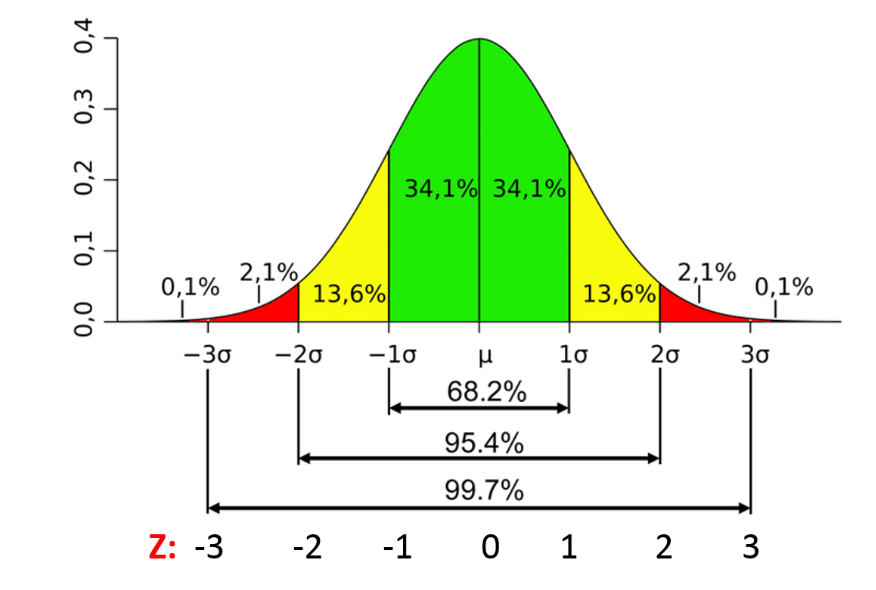

In [34]:
ND_out=['V9','V10','V13','V15','V19','V20','V21','V22','V25','V27'] #by oberving the distribution diagrams
df_train.shape#checking the shape before outliers treatment

(256326, 33)

In [35]:
#normal distributed outliers treatment by [min :mean-3*(sigma) or above: mean+3*(sigma)]
j=0
ND_h=[]
ND_l=[]
for i in ND_out[:]:
    m=min(df_train[i].max(),abs(df_train[i].min()))
    ND_h.append(round(df_train[i].mean() + (m-((m//5)*1.25))*df_train[i].std(),1))
    ND_l.append(round(df_train[i].mean() - (m-((m//5)*1.25))*df_train[i].std(),1))
    new_df = df_train[(df_train[i] < ND_h[j]) & (df_train[i] > ND_l[j])]
    df_train[i] = np.where( df_train[i]>ND_h[j],ND_h[j],np.where( df_train[i]<ND_l[j],  ND_l[j],  df_train[i] ))
    j=j+1

In [36]:
df_train.shape,new_df.shape #checking

((256326, 33), (255160, 33))

## **For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.**

– The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers, where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

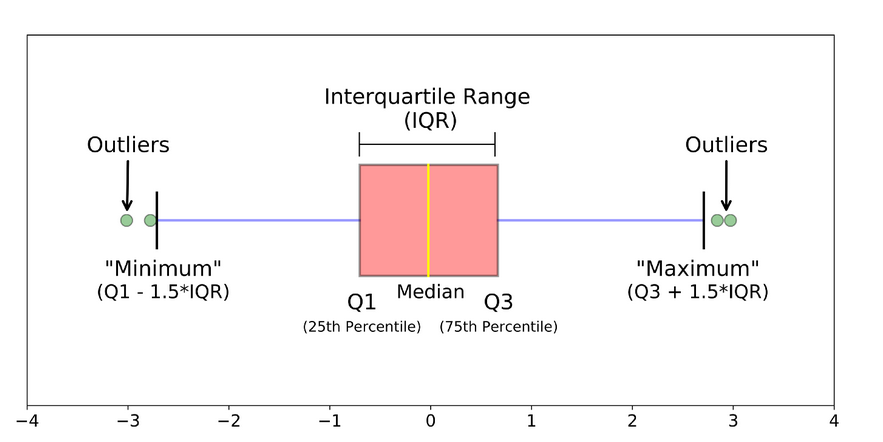

In [37]:
SD_out=['V1','V2','V3','V4','V5','V6','V7','V8','V11','V12','V14','V16','V17','V18','V23','V26'] #by oberving the distribution diagrams

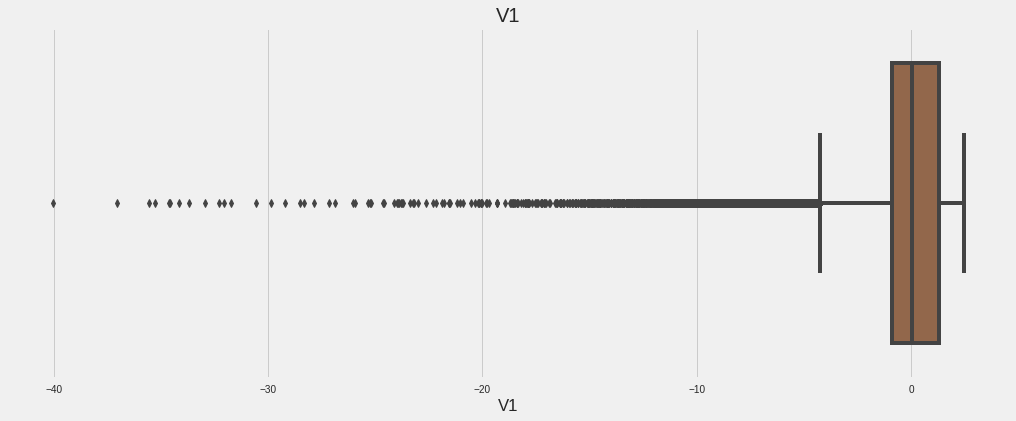

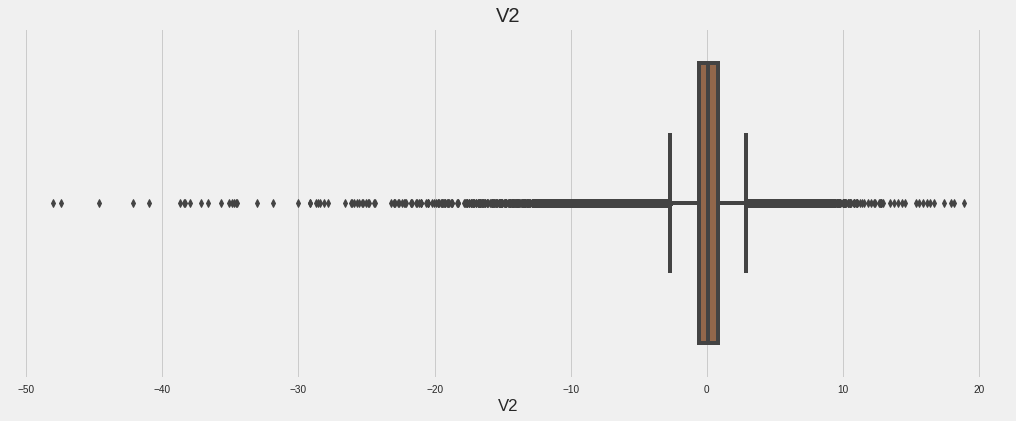

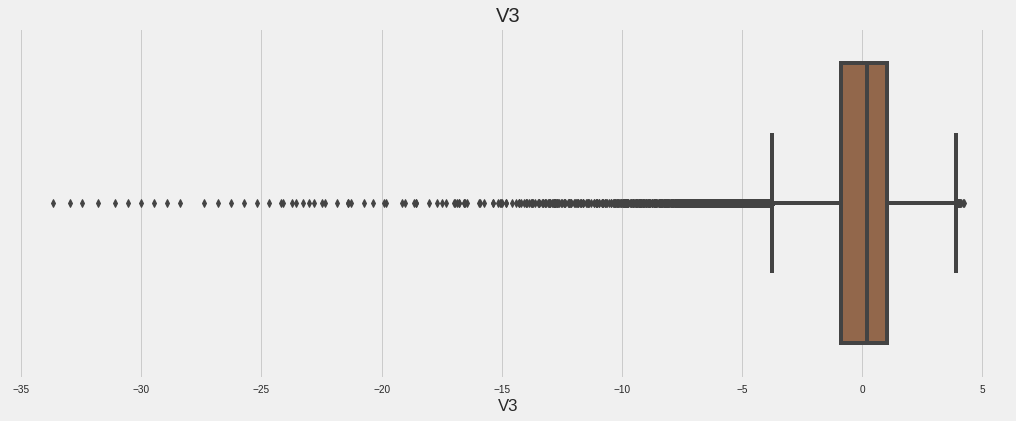

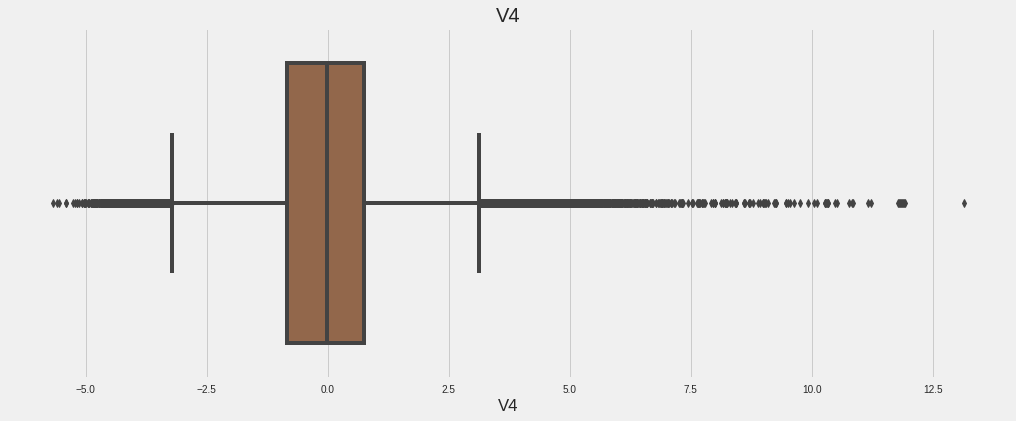

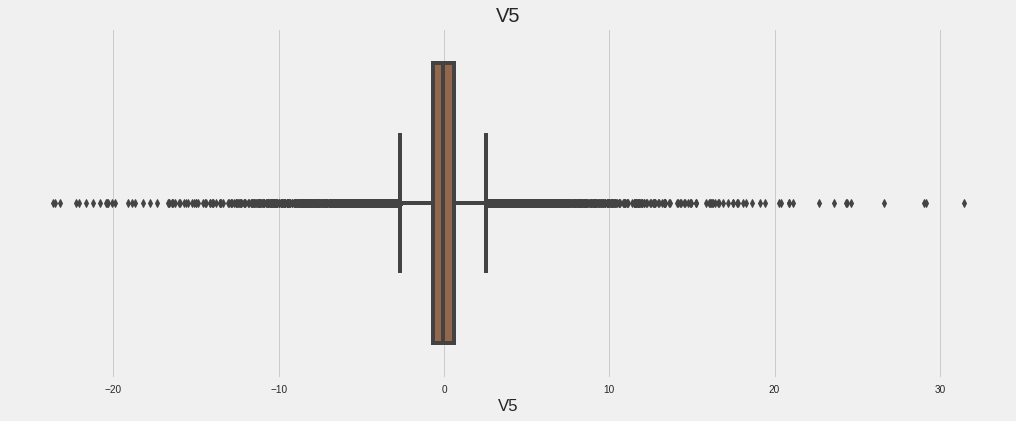

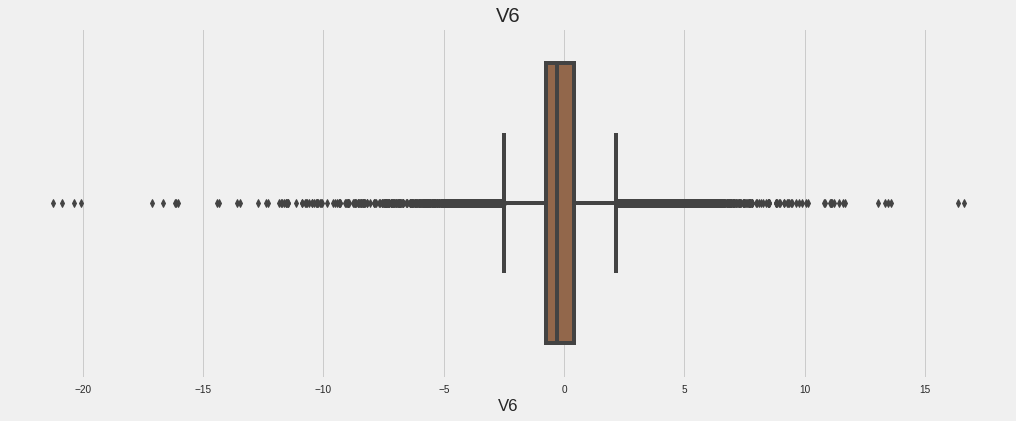

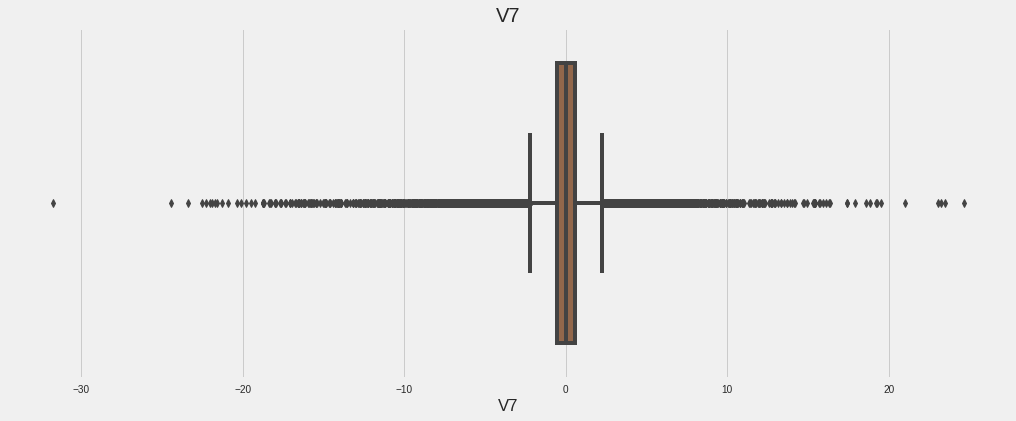

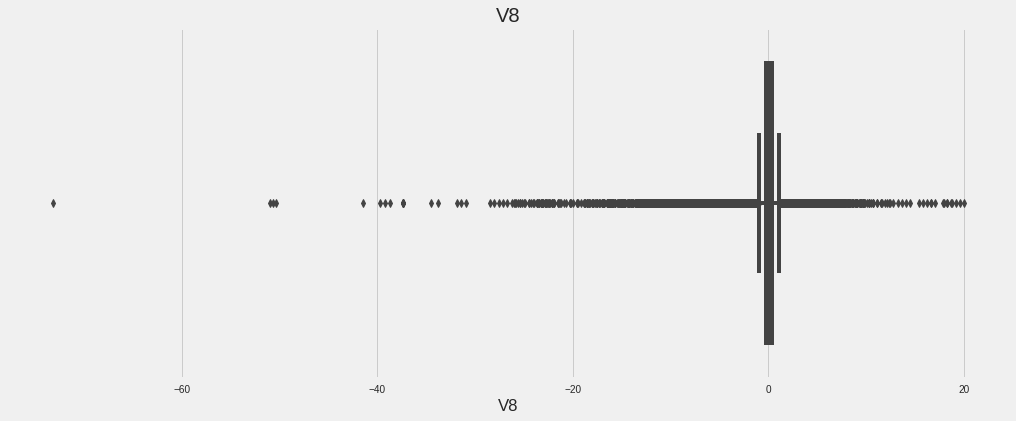

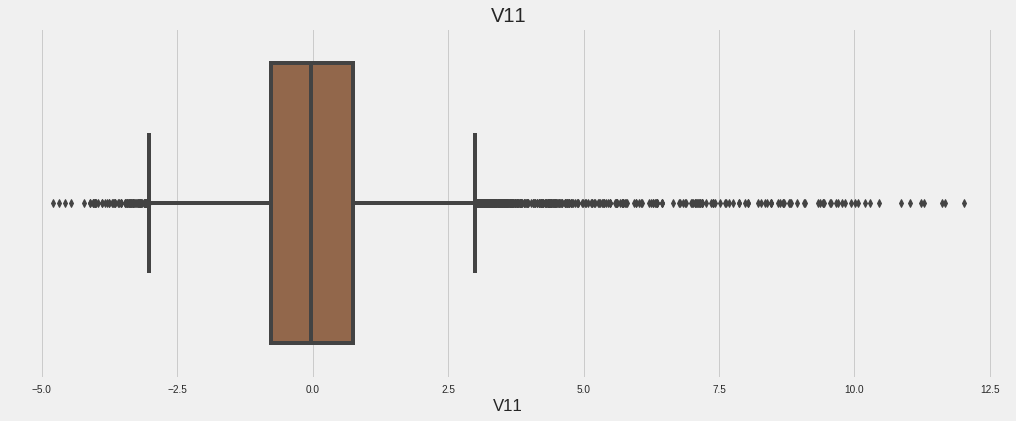

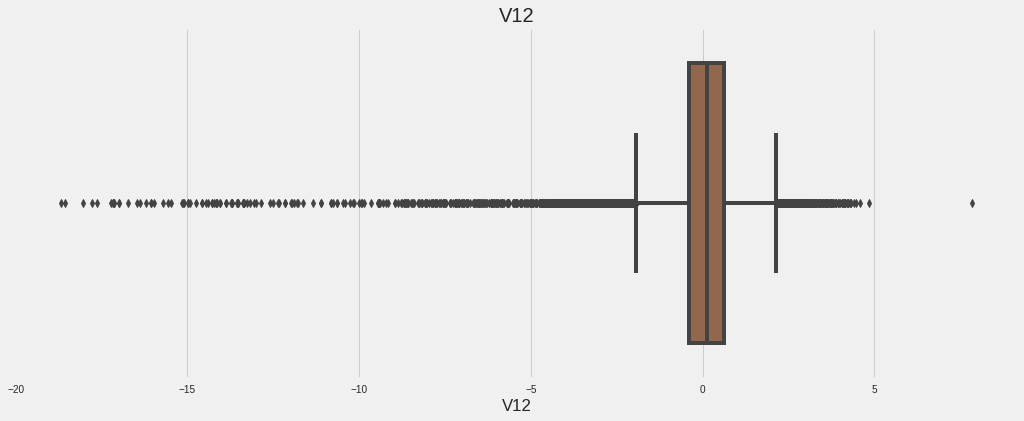

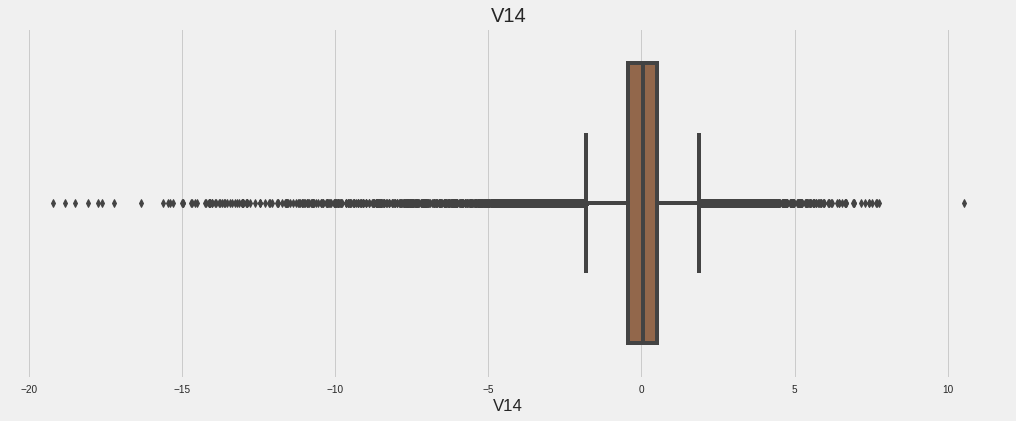

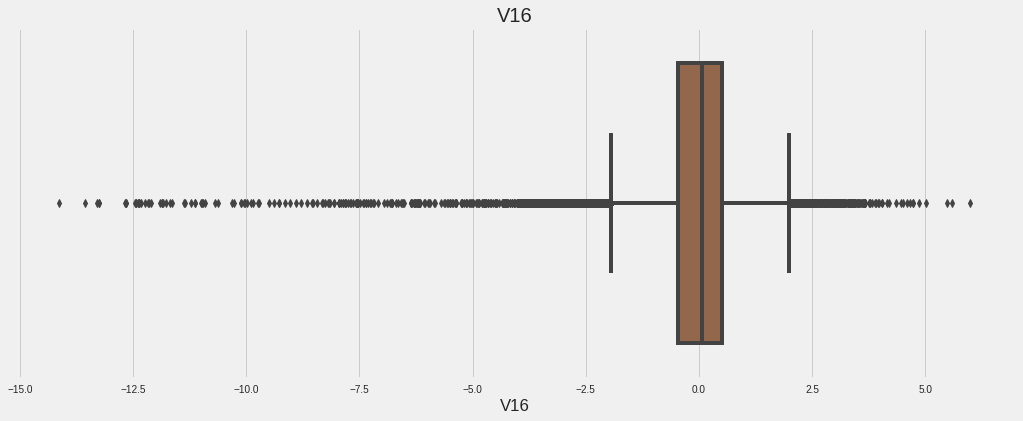

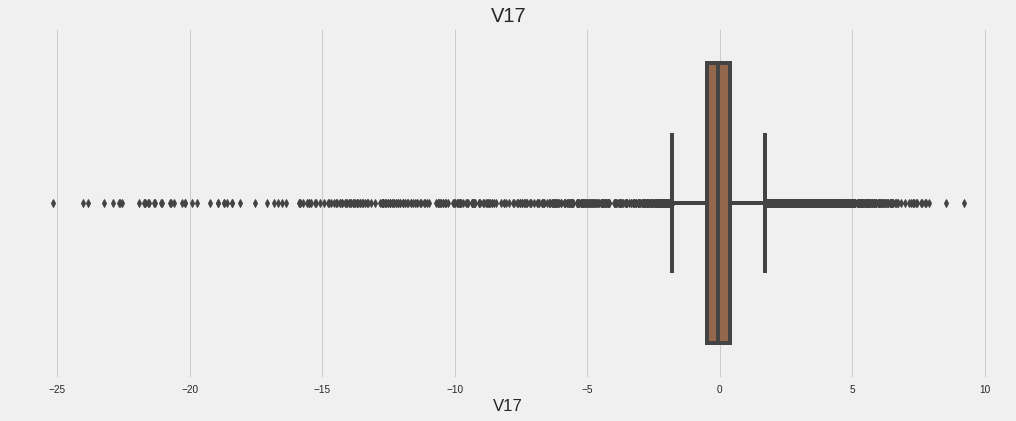

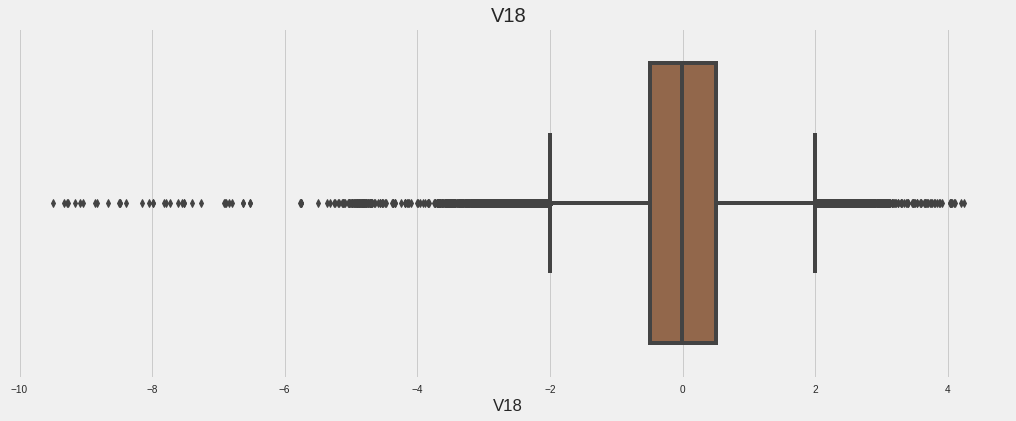

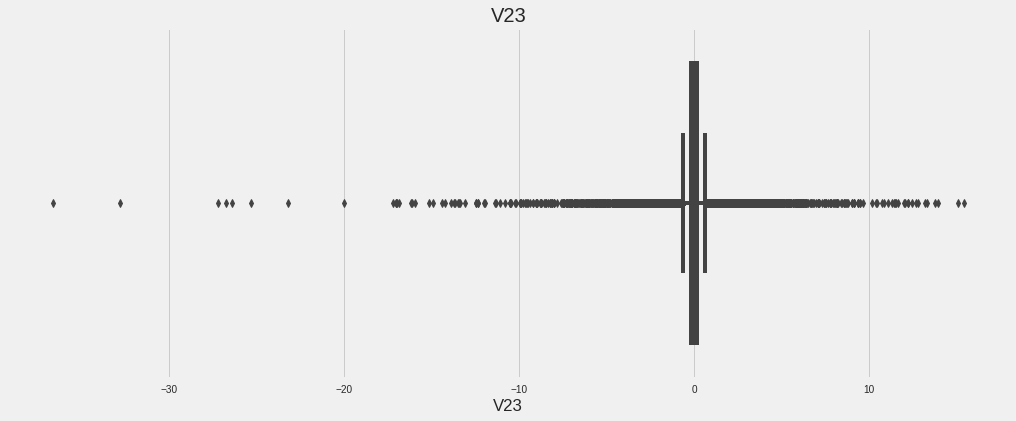

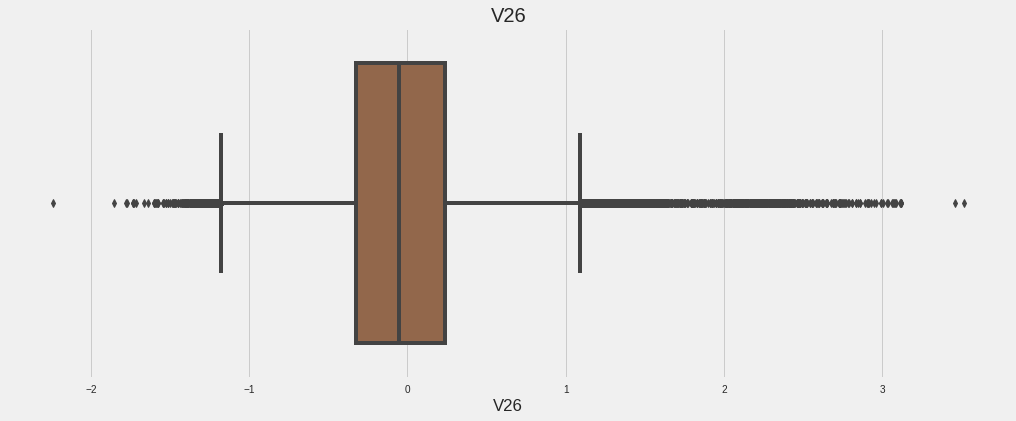

In [38]:
#checking outliers
for i in SD_out[:]:
  plt.figure(figsize = (16,6))
  sns.boxplot(new_df[i], orient="h", palette = 'copper')
  plt.title(i)
  plt.show()

In [39]:
#Skewed distribution outliers treatment
for i in SD_out[:]:
    p25 = new_df[i].quantile(0.25)
    p75 = new_df[i].quantile(0.75)
    iqr=p75-p25
    ul = p75 + 1.5 * iqr
    ll = p25 - 1.5 * iqr
    new_df1 = new_df[new_df[i] < ul]#trimming
    #capping
    new_df[i] = np.where( 
    new_df[i] > ul,
    ul,
    np.where(
        new_df[i] < ll,
        ll,
        new_df[i]
            )
    )

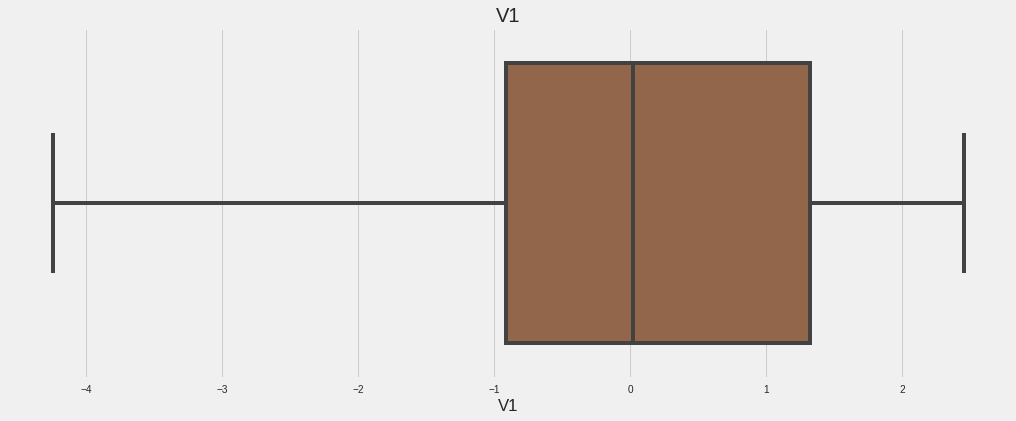

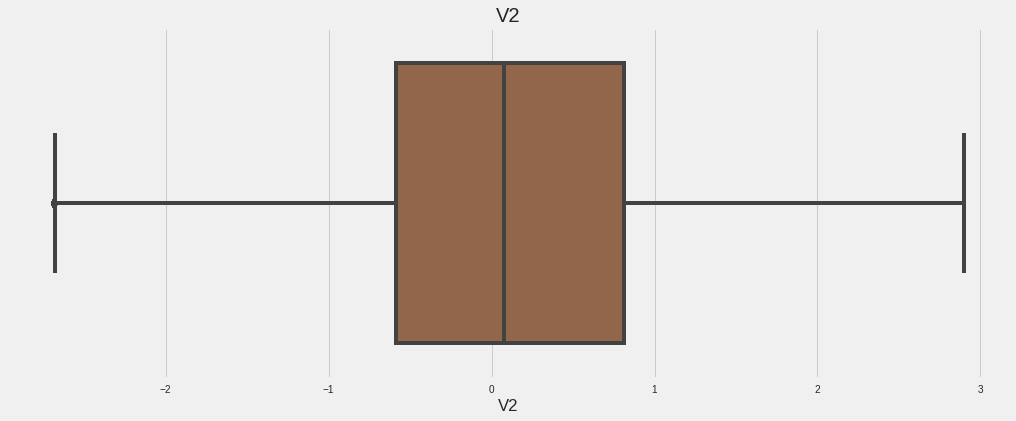

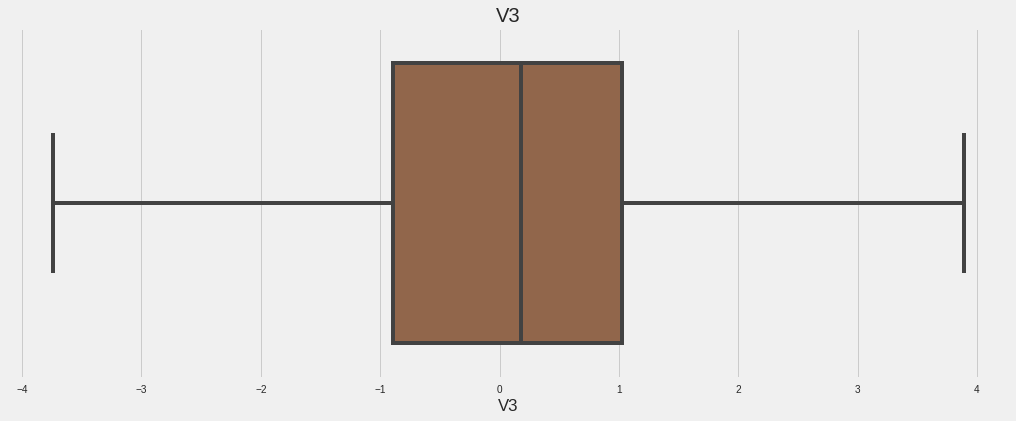

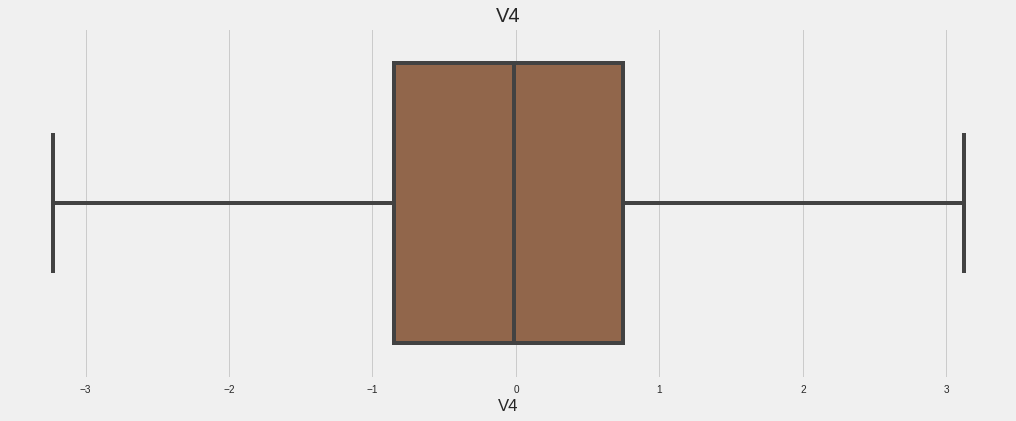

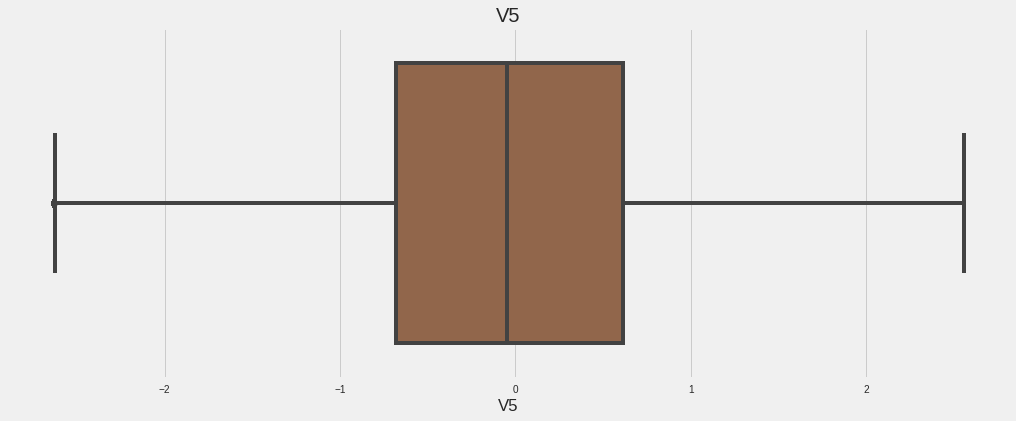

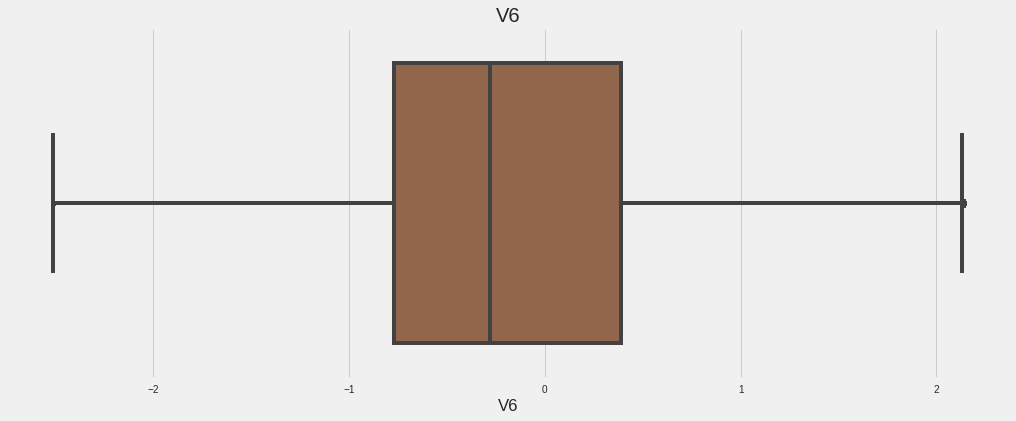

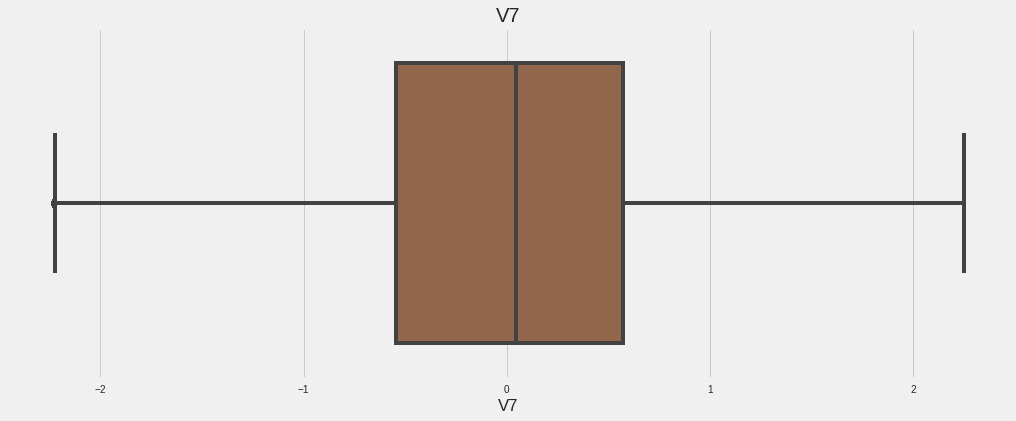

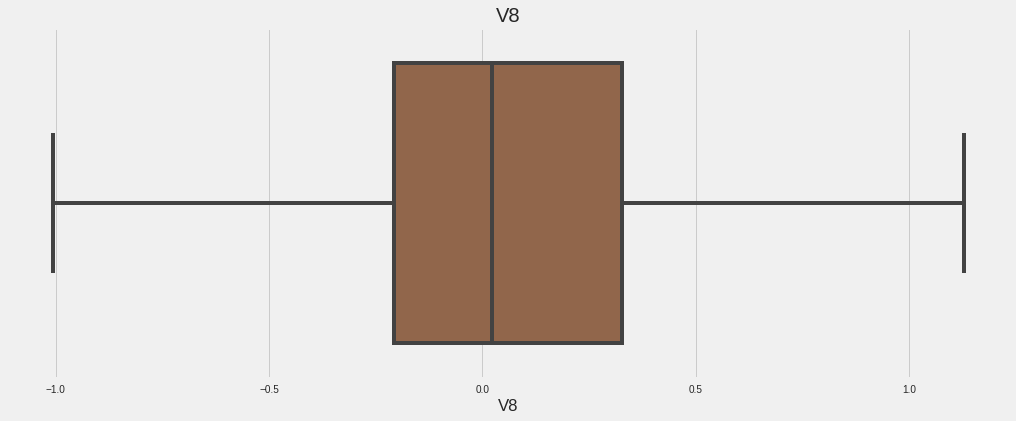

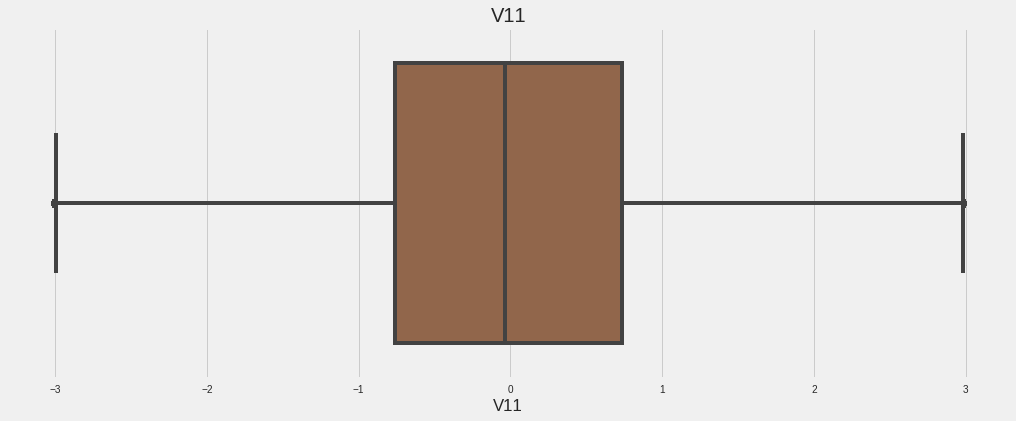

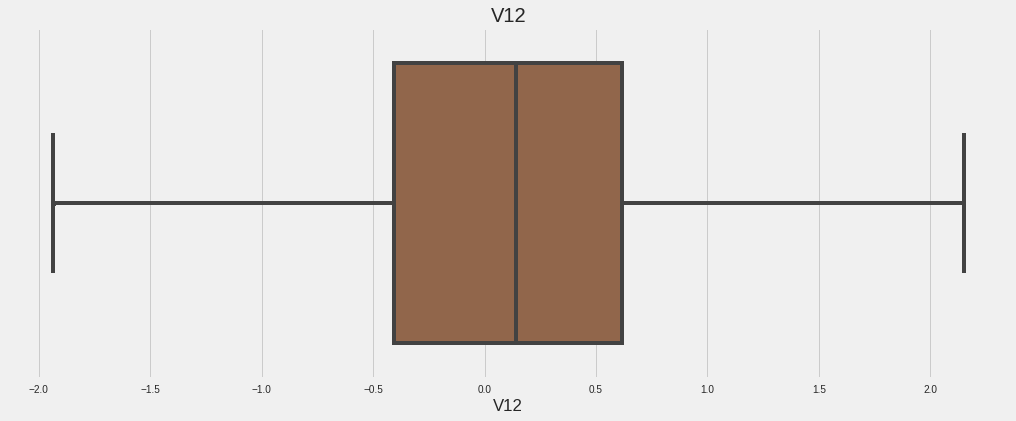

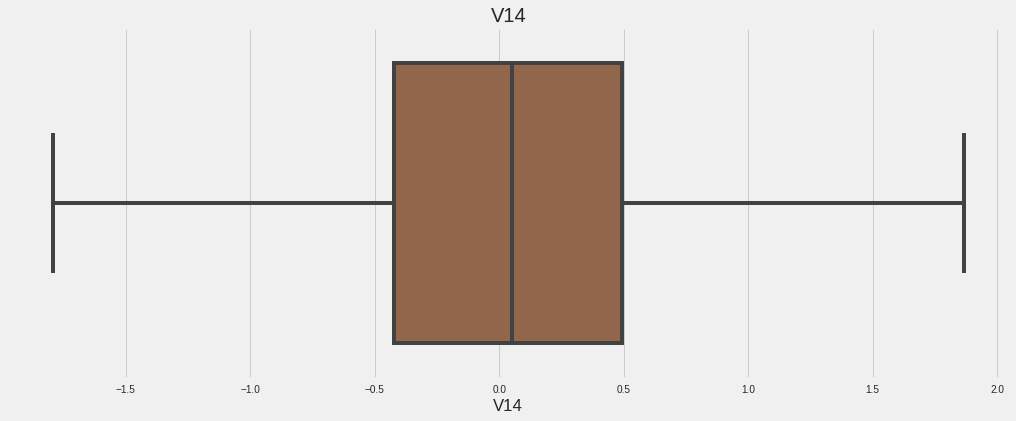

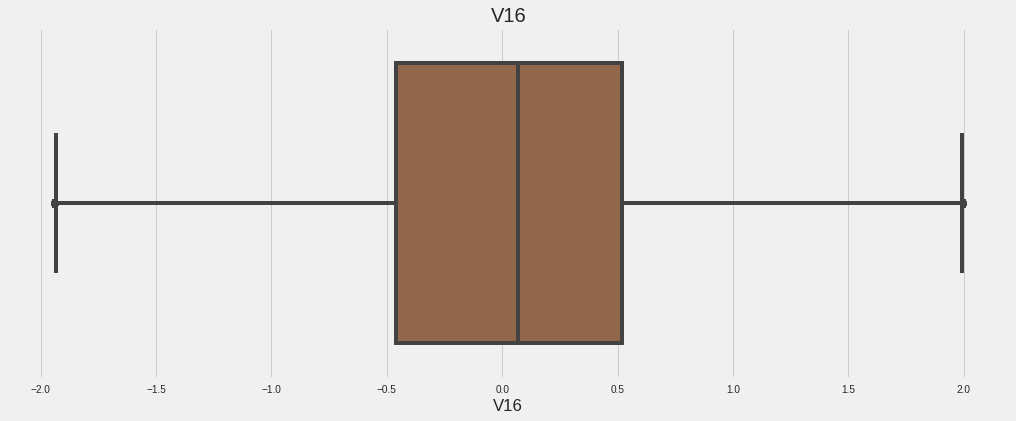

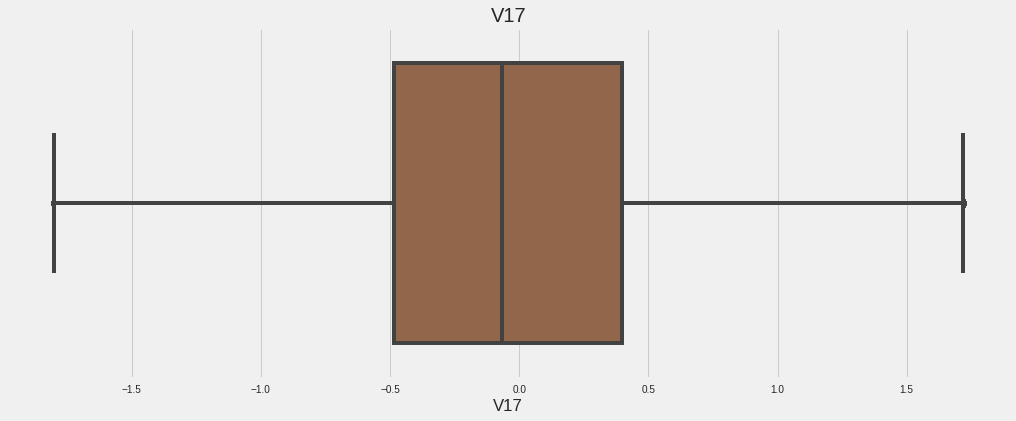

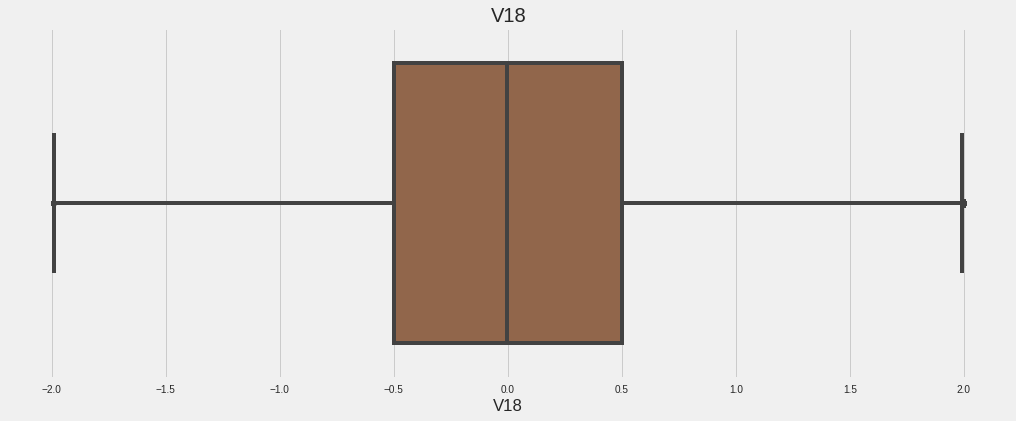

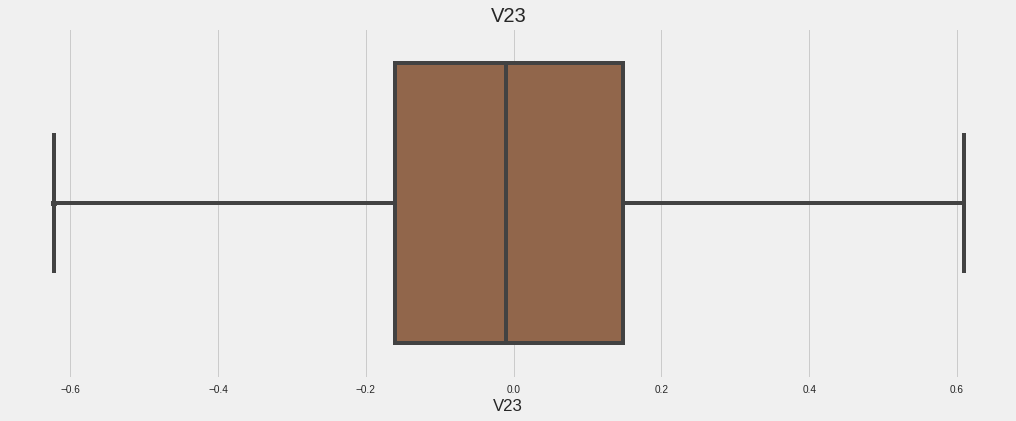

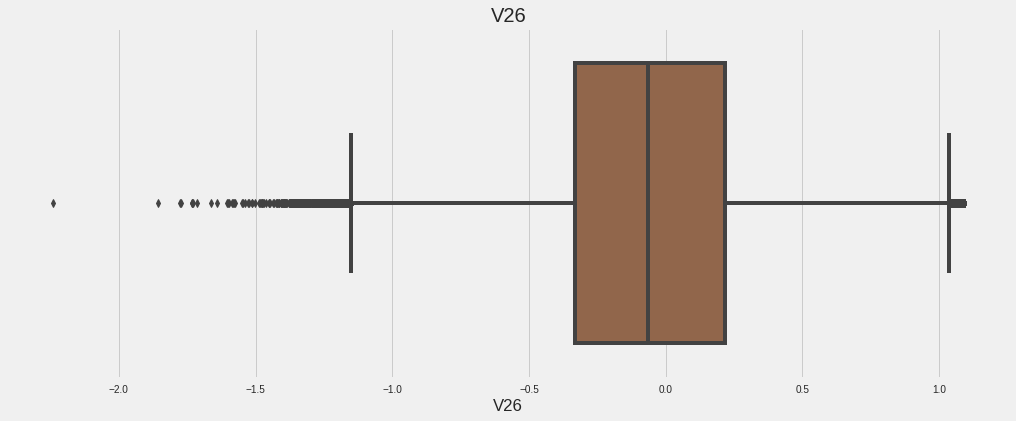

In [40]:
#checking after outliers treatment
for i in SD_out[:]:
  plt.figure(figsize = (16,6))
  sns.boxplot(new_df1[i], orient = 'h', palette = 'copper_r')
  plt.title(i)
  plt.show()

In [20]:
new_df.shape,new_df1.shape

((256291, 33), (251873, 33))

# **Other distribution variables outliers treatment by percentile method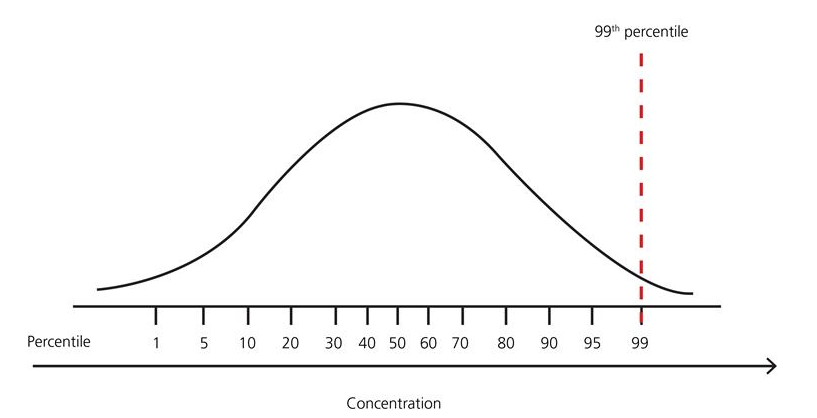**

In [41]:
OD_out=['V24','V28','Amount'] #by oberving the distribution diagrams

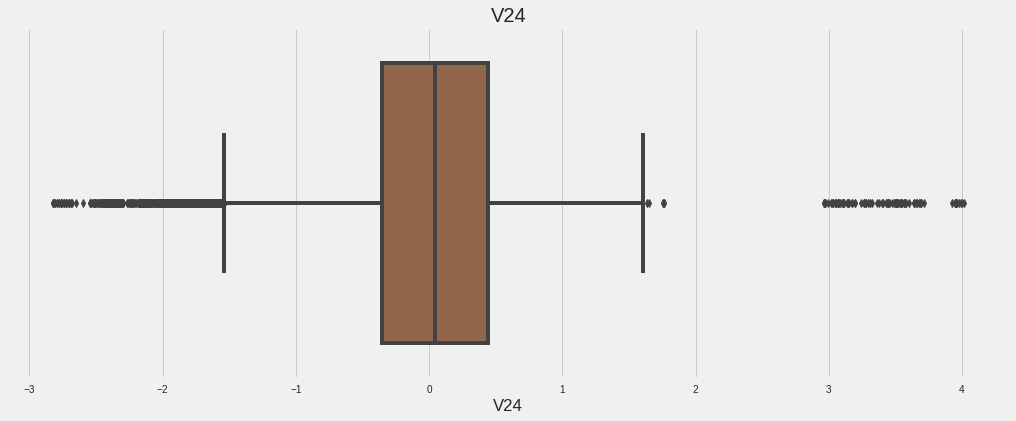

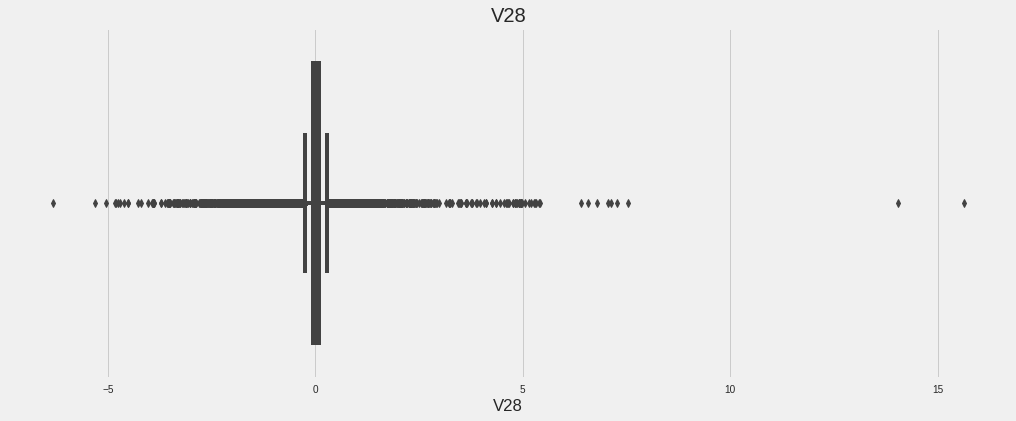

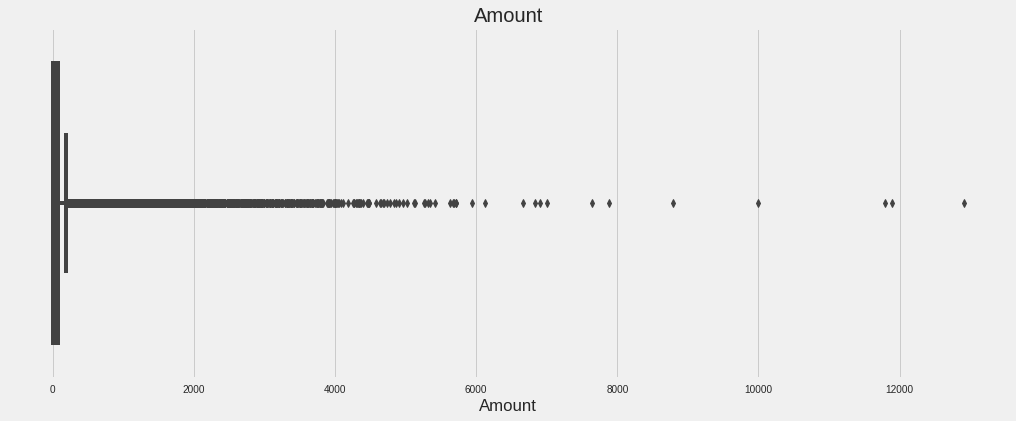

In [42]:
#checking the outliers
for i in OD_out[:]:
  plt.figure(figsize = (16,6))
  sns.boxplot(new_df1[i], orient = 'h', palette = 'copper_r')
  plt.title(i)
  plt.show()

In [43]:
#Other distributed outliers treatment by percentile
for i in OD_out[:]:
    upper_limit = new_df1[i].quantile(0.99)
    lower_limit = new_df1[i].quantile(0.01)
    new_df2 = new_df1[(new_df1[i] <= upper_limit) & (new_df1[i] >= lower_limit)]#trimming
    #capping
    new_df1[i] = np.where(new_df1[i] >= upper_limit,
            upper_limit,
            np.where(new_df1[i] <= lower_limit,
            lower_limit,
            new_df1[i]))

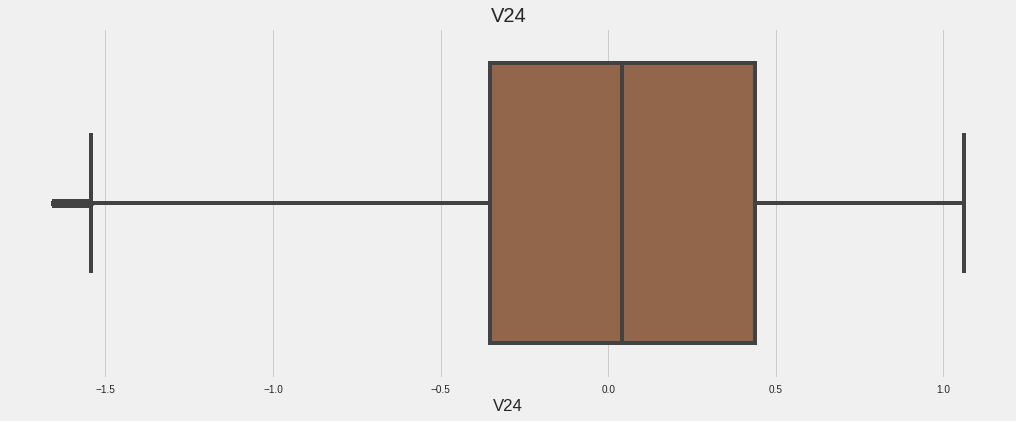

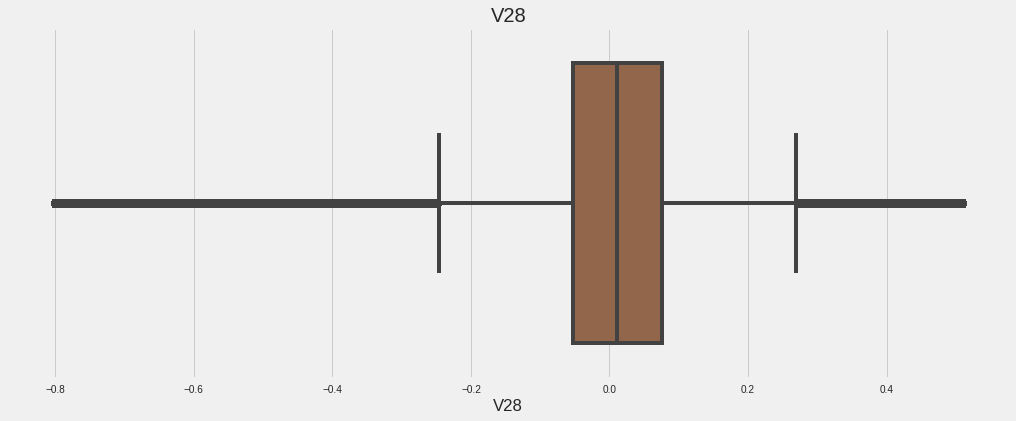

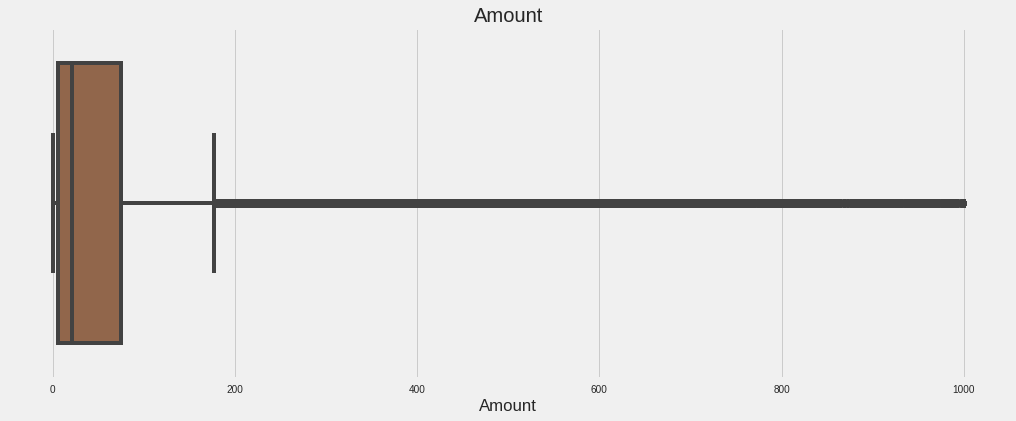

In [44]:
#after treatment
for i in OD_out[:]:
  plt.figure(figsize = (16,6))
  sns.boxplot(new_df2[i], orient = 'h', palette = 'copper_r'  )
  plt.title(i)
  plt.show()

In [45]:
#comparing shapes, our final data frame after removing outliers is new_df2
new_df1.shape, new_df2.shape

((250732, 33), (245902, 33))

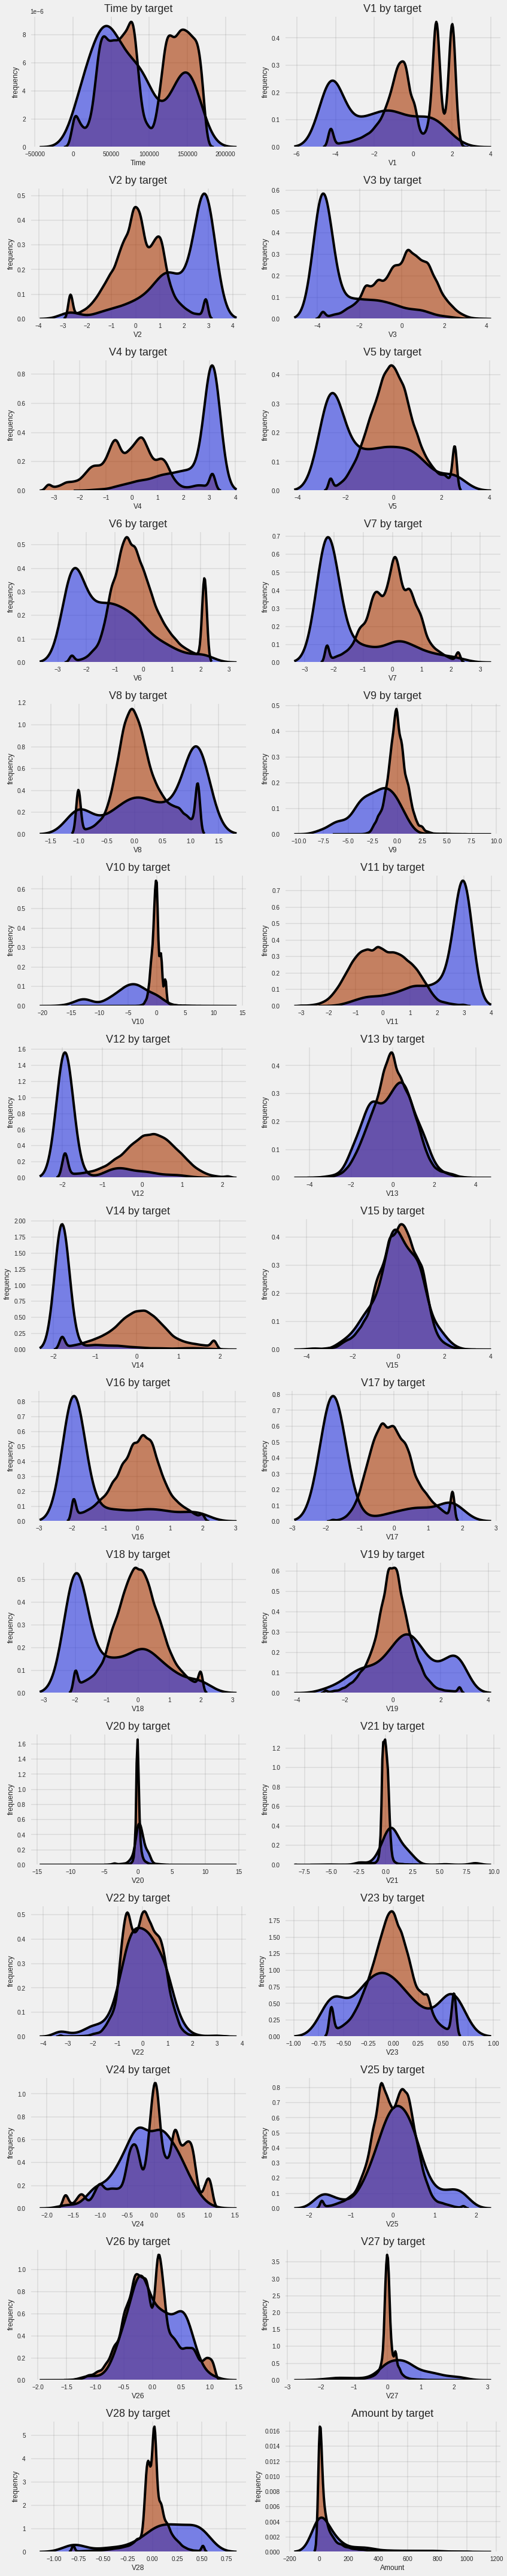

CPU times: user 59 s, sys: 4.24 s, total: 1min 3s
Wall time: 59.3 s


In [46]:
f,ax=plt.subplots(15,2,figsize=(12,60))
#f.delaxes(ax)
col = list(new_df2.drop(['id','kfold'], axis = 1))
col = [e for e in col if e not in ('Class')]

for i,feature in enumerate(col):
    sns.distplot(new_df2.drop(['id','kfold'], axis = 1)[new_df2.drop(['id','kfold'], axis = 1)['Class']==1].dropna()[(feature)], ax=ax[i//2,i%2], kde_kws={"color":"black"}, hist=False )
    sns.distplot(new_df2.drop(['id','kfold'], axis = 1)[new_df2.drop(['id','kfold'], axis = 1)['Class']==0].dropna()[(feature)], ax=ax[i//2,i%2], kde_kws={"color":"black"}, hist=False )

    # Get the two lines from the ax[i//2,i%2]es to generate shading
    l1 = ax[i//2,i%2].lines[0]
    l2 = ax[i//2,i%2].lines[1]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    x2 = l2.get_xydata()[:,0]
    y2 = l2.get_xydata()[:,1]
    ax[i//2,i%2].fill_between(x2,y2, color="#A73602", alpha=0.6)
    ax[i//2,i%2].fill_between(x1,y1, color="#2734DE", alpha=0.6)

    #grid
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.3)
    
    ax[i//2,i%2].set_title('{} by target'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('Modality', fontsize=12)

    #sns.despine(ax[i//2,i%2]=ax[i//2,i%2], left=True)
    ax[i//2,i%2].set_ylabel("frequency", fontsize=12)
    ax[i//2,i%2].set_xlabel(str(feature), fontsize=12)

plt.tight_layout()
plt.show()

## **What does Imbalanced Data do?**
- Let's understand using sample of the new_df2 data and train 3 models on them.
- We will use Isolation Forest Algorithm and Local Outlier Factor (LOF) as these two algorithm will not be impacted by imbalanced data.
- Finally we will use Support Vector Machine (SVM) as that will be affected by imbalanced data.  

In [48]:
## Take some sample of the data
data= new_df2.sample(frac = 0.1,random_state=1)
data.shape

(24590, 33)

In [49]:
#Create independent and Dependent Features
columns = data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["id","Class", "kfold"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(24590, 30)
(24590,)


In [50]:
#Determine the number of fraud and valid transactions in the dataset
Fraud = data[data['Class']==1]
Valid = data[data['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

## **Isolation Forest Algorithm :**

---



- One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

- This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

- Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

- How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

- The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

## **Local Outlier Factor(LOF) Algorithm**

---



- The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

- The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [51]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [52]:
%%time
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 69
Accuracy Score :
0.9971939812932086
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24538
           1       0.34      0.35      0.34        52

    accuracy                           1.00     24590
   macro avg       0.67      0.67      0.67     24590
weighted avg       1.00      1.00      1.00     24590

Local Outlier Factor: 103
Accuracy Score :
0.9958113054087028
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24538
           1       0.02      0.02      0.02        52

    accuracy                           1.00     24590
   macro avg       0.51      0.51      0.51     24590
weighted avg       1.00      1.00      1.00     24590

Support Vector Machine: 8378
Accuracy Score :
0.6592923952826352
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.66  


### **Observations :**

---



- Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 20495 errors
- Isolation Forest has a 99.73% more accurate than LOF of 99.61% and SVM of 64.94
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases



# **Taking care of Imbalanced Dataset**
## **Using ``SMOTETomek`` for Oversampling**

## **Oversampling**

**Oversampling is just the opposite of undersampling. Here the class containing less data is made equivalent to the class containing more data. This is done by adding more data to the least sample containing class.** 

## **Undersampling**

**This technique samples down or reduces the samples of the class containing more data equivalent to the class containing the least samples. Suppose class A has 900 samples and class B has 100 samples, then the imbalance ratio is 9:1. Using the undersampling technique we keep class B as 100 samples and from class A we randomly select 100 samples out of 900. Then the ratio becomes 1:1 and we can say it’s balanced.**

## **SMOTETomek**

**SMOTETomek is somewhere upsampling and downsampling. SMOTETomek is a hybrid method which is a mixture of the above two methods, it uses an under-sampling method (Tomek) with an oversampling method (SMOTE). This is present within imblearn.combine module.**

In [53]:
#Create independent and Dependent Features
columns = new_df2.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["id","Class", "kfold"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = new_df2[columns]
Y = new_df2[[target]]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(245902, 30)
(245902, 1)


## **Let's see what does SMOTETomek actually does and later we will use it again when training xtrain and testing in xvalid.**

In [54]:
%%time
from imblearn.combine import SMOTETomek
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
col_X = list(X.columns)
col_y = list(Y.columns)
X_res,y_res=smk.fit_sample(X,Y)
X_res = pd.DataFrame(X_res, columns = col_X)
y_res = pd.DataFrame(y_res, columns = col_y)
print(X_res.shape,y_res.shape)

(489032, 30) (489032, 1)
CPU times: user 19.9 s, sys: 203 ms, total: 20.1 s
Wall time: 20 s


In [55]:
from collections import Counter
print(f'Original dataset shape {Counter(Y)}')
print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape Counter({'Class': 1})
Resampled dataset shape Counter({'Class': 1})
